In [1]:
import pandas as pd # for reading and intreacting with dataframes 
import seaborn as sns #for advanced graphs 
import matplotlib.pyplot as plt  #for plotting graphs
import os #for interacting with system hardware
import numpy as np #for handling arrays
import mysql.connector # for connecting with SQL
plt.style.use('seaborn') #use the style provided in seaborn library

# CONSTANTS 

In [2]:
# file paths to various encoders
LABEL_ENCODER_PATH = 'D:/5th Sem/ML/FinalDataset/Objects/Encoders/LabelEncoder/'
LAYOUT_ENCODER_PATH = 'D:/5th Sem/ML/FinalDataset/Objects/Encoders/OrdinalEncoder/layout_type/'
PROPERTY_ENCODER_PATH = 'D:/5th Sem/ML/FinalDataset/Objects/Encoders/OrdinalEncoder/property_type/'
SELLER_ENCODER_PATH = 'D:/5th Sem/ML/FinalDataset/Objects/Encoders/OrdinalEncoder/seller_type/'
FURNITURE_ENCODER_PATH = 'D:/5th Sem/ML/FinalDataset/Objects/Encoders/OrdinalEncoder/furniture_encoders/'
# city list 
CITIES = ['AHEMDABAD','BANGALORE','CHENNAI','DELHI','HYDERABAD','KOLKATA','MUMBAI','PUNE']
# for plotting 
PIE_NROWS = 2
PIE_NCOLS = 2
NUMERICAL_NROWS = 2
NUMERICAL_NCOLS = 2
REGULAR_FIGSIZE = (16,6)
PIE_FIGSIZE=(20,15)
MULTICOL_FIGSIZE=(16,8)
# for saving plots 
AFFORDABILITY_PLOT_DESTINATION = 'static/Affordability/'
OTHER_PLOT_DESTINATION = 'static/Other/'
NUMERICAL_PLOT_DESTINATION = 'static/Numerical/'
SPACIOUS_PLOT_DESTINATION = 'static/Spacious/'
OVERALL_NUMERICAL_ANALYSIS_PATH = 'static/Overall'
with open('credentials.txt','r') as f:
    PASSWORD = f.read()

# Connecting to SQL

In [3]:
conn = mysql.connector.connect(
    host='34.93.147.30',
    port=3306,
    user='root',
    password=PASSWORD,
    database='CLEAN',
    auth_plugin='mysql_native_password'
)

In [4]:
df_list = [pd.read_sql(f'SELECT * FROM {city}', con=conn) for city in CITIES]
conn.close()

In [5]:
df_dict = dict(zip(CITIES,df_list))

In [6]:
cols = ['SELLER TYPE','BEDROOM','LAYOUT TYPE','PROPERTY TYPE','LOCALITY','PRICE','AREA','FURNISH TYPE','BATHROOM']
for city, df in df_dict.items():
    # create a city column for all dataframes for identification while combining 
    df.columns = cols
    df['CITY'] = city
    df['AFFORDABILITY'] = df['PRICE']/df['AREA']

In [7]:
combined = pd.concat(df_list)

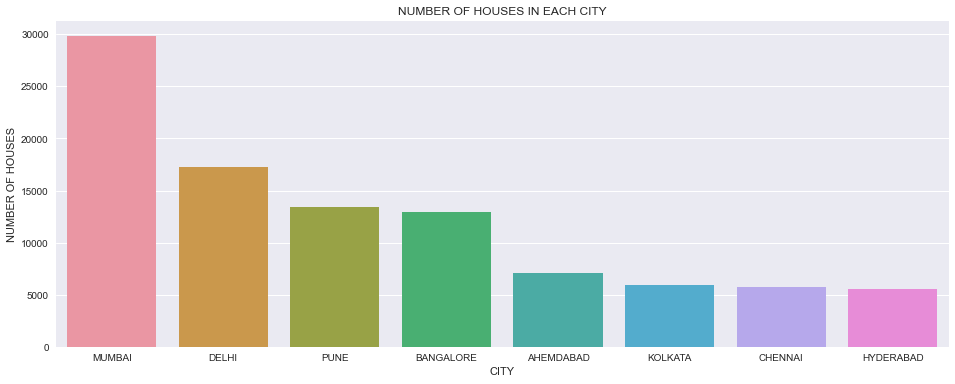

In [8]:
fig, ax = plt.subplots(figsize=REGULAR_FIGSIZE)
sns.countplot(x=combined['CITY'],ax=ax,order=combined['CITY'].value_counts().index)
ax.set_title('NUMBER OF HOUSES IN EACH CITY')
ax.set_xlabel('CITY')
ax.set_ylabel('NUMBER OF HOUSES')
if not os.path.exists(OVERALL_NUMERICAL_ANALYSIS_PATH):
    os.makedirs(OVERALL_NUMERICAL_ANALYSIS_PATH)
plt.savefig(os.path.join(OVERALL_NUMERICAL_ANALYSIS_PATH, 'n_houses.png'))
plt.show()

In [9]:
# create a list of columns to be analyszed numerically for all cities
overall_numerical_cols = ['PRICE','AREA','AFFORDABILITY']

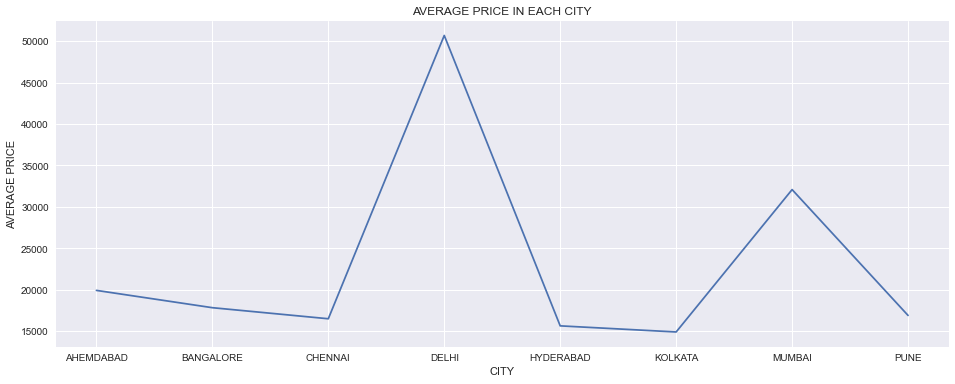

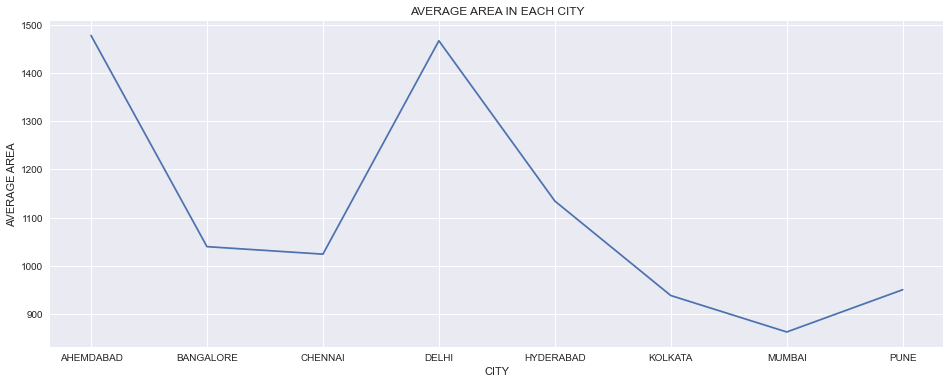

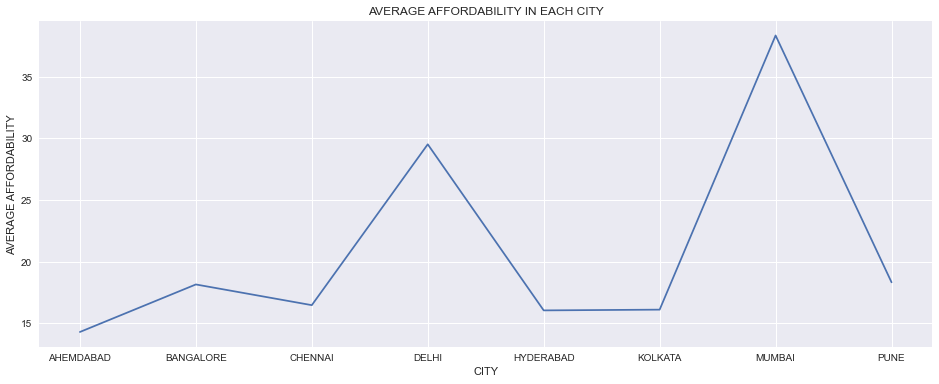

In [10]:
for col in overall_numerical_cols:
    fig, ax = plt.subplots(figsize=REGULAR_FIGSIZE)
    mean_df = combined.groupby(by=['CITY'])[col].mean()
    sns.lineplot(x=mean_df.index, y=mean_df, ax=ax)
    ax.set_xlabel('CITY')
    ax.set_ylabel(f'AVERAGE {col}')
    ax.set_title(f'AVERAGE {col} IN EACH CITY')
    plt.savefig(os.path.join(OVERALL_NUMERICAL_ANALYSIS_PATH, f'{col}.png'))
    plt.show()

In [11]:
# create list of columns to be analyzed as pie chart for each dataframe
pie_cols = np.array(['SELLER TYPE','LAYOUT TYPE','PROPERTY TYPE','FURNISH TYPE']).reshape(PIE_NROWS,PIE_NCOLS)

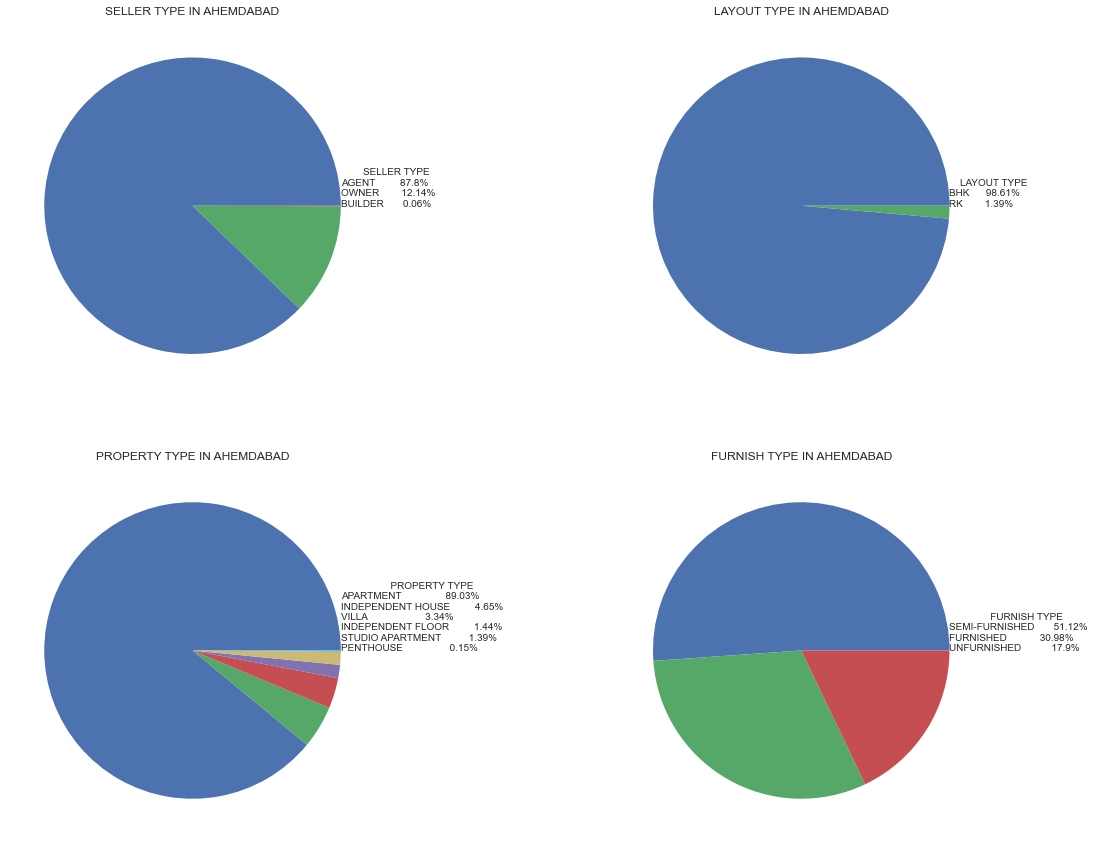

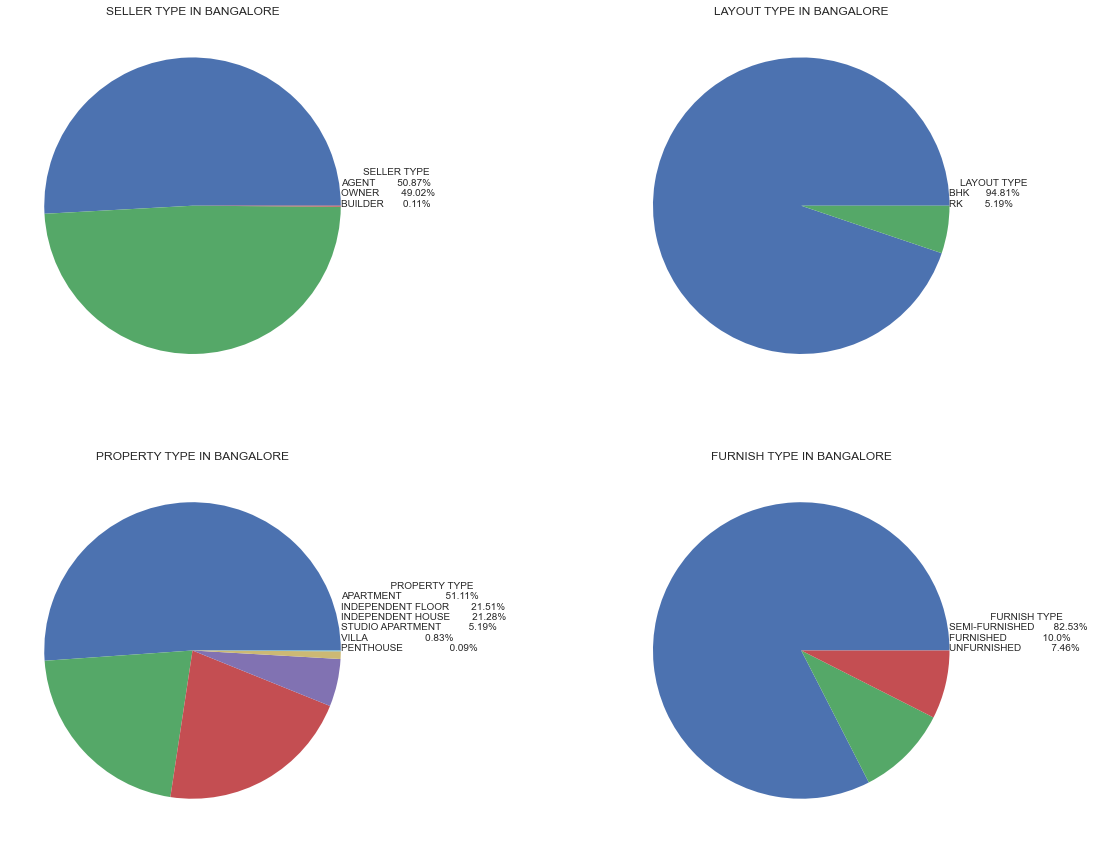

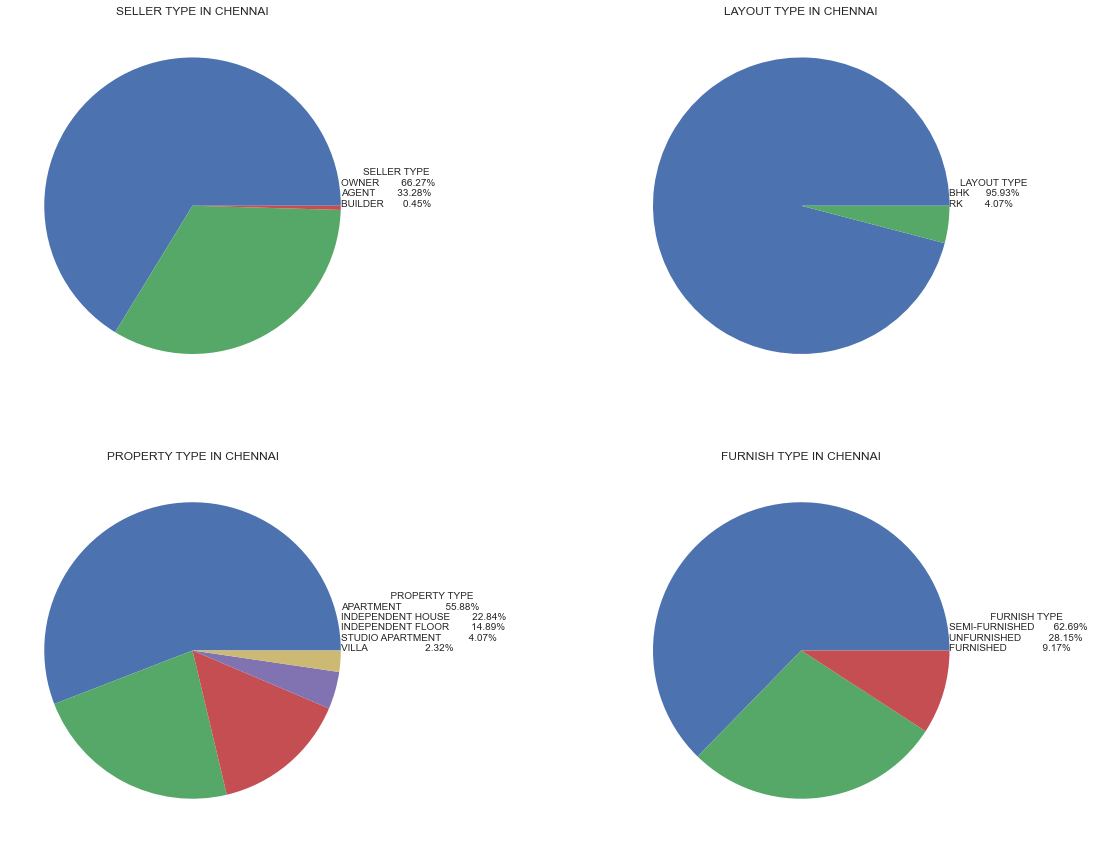

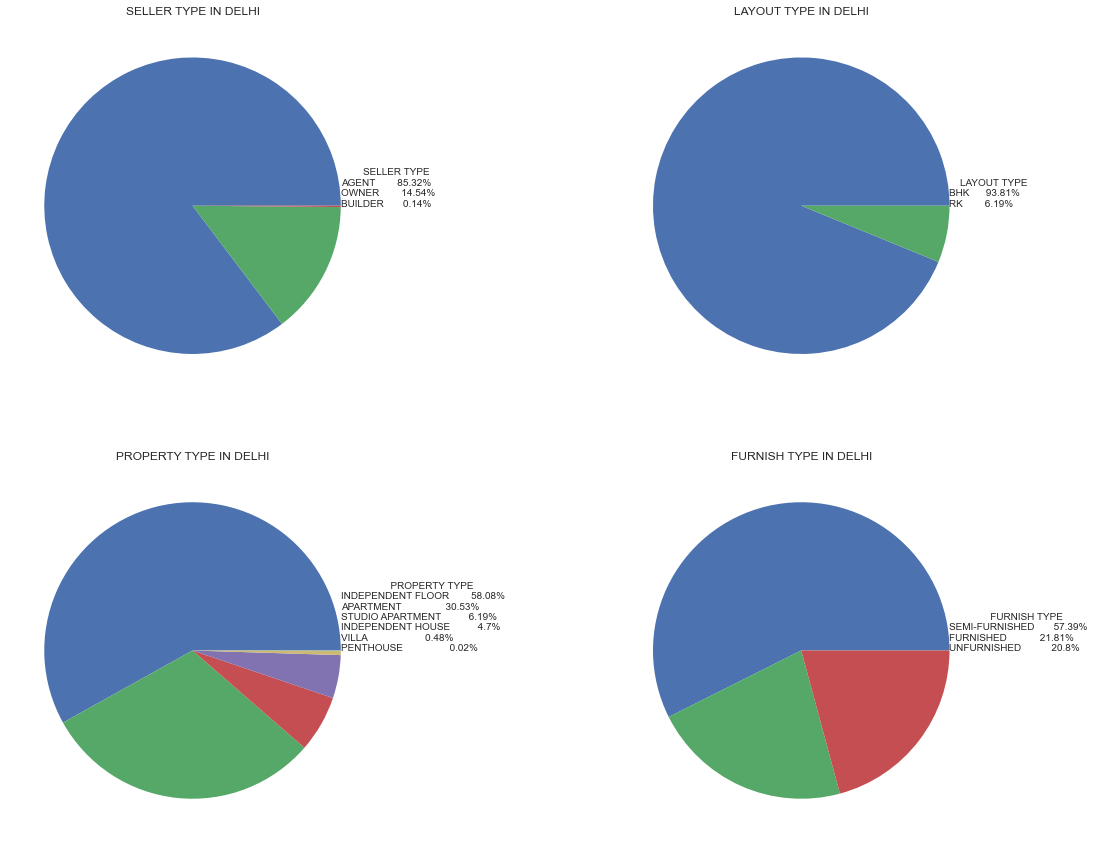

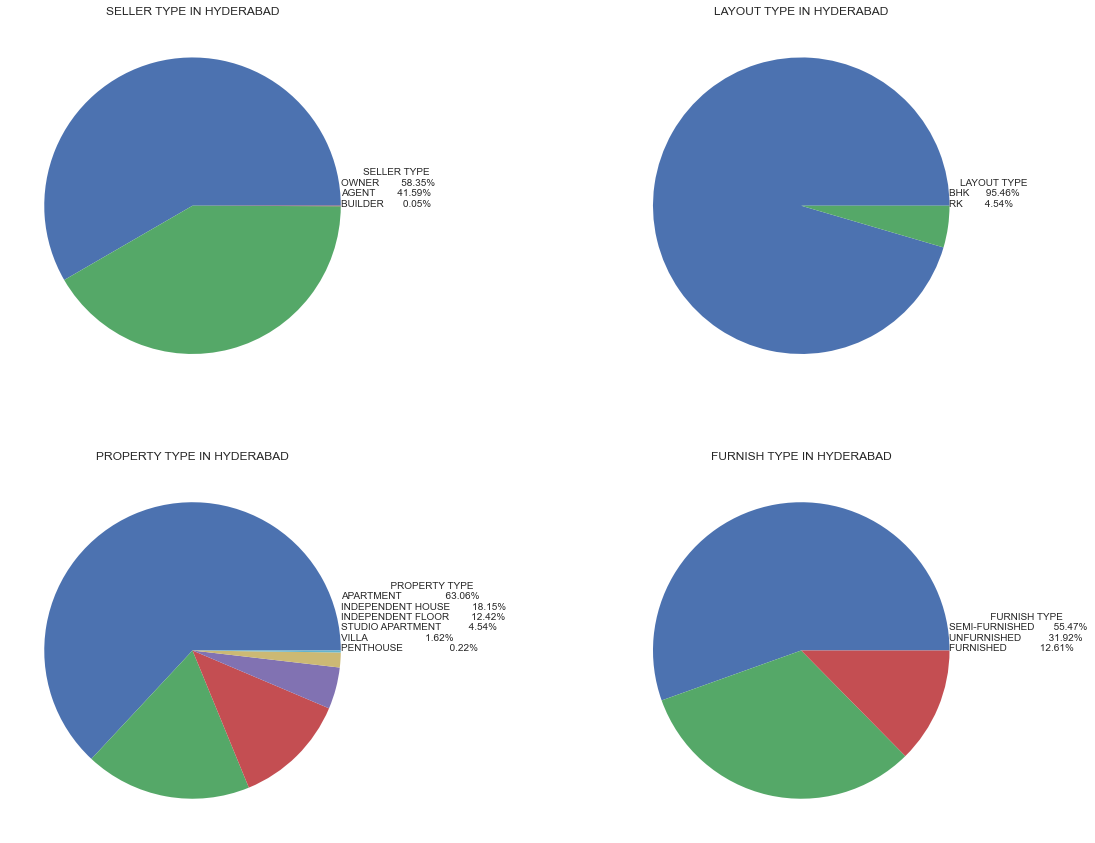

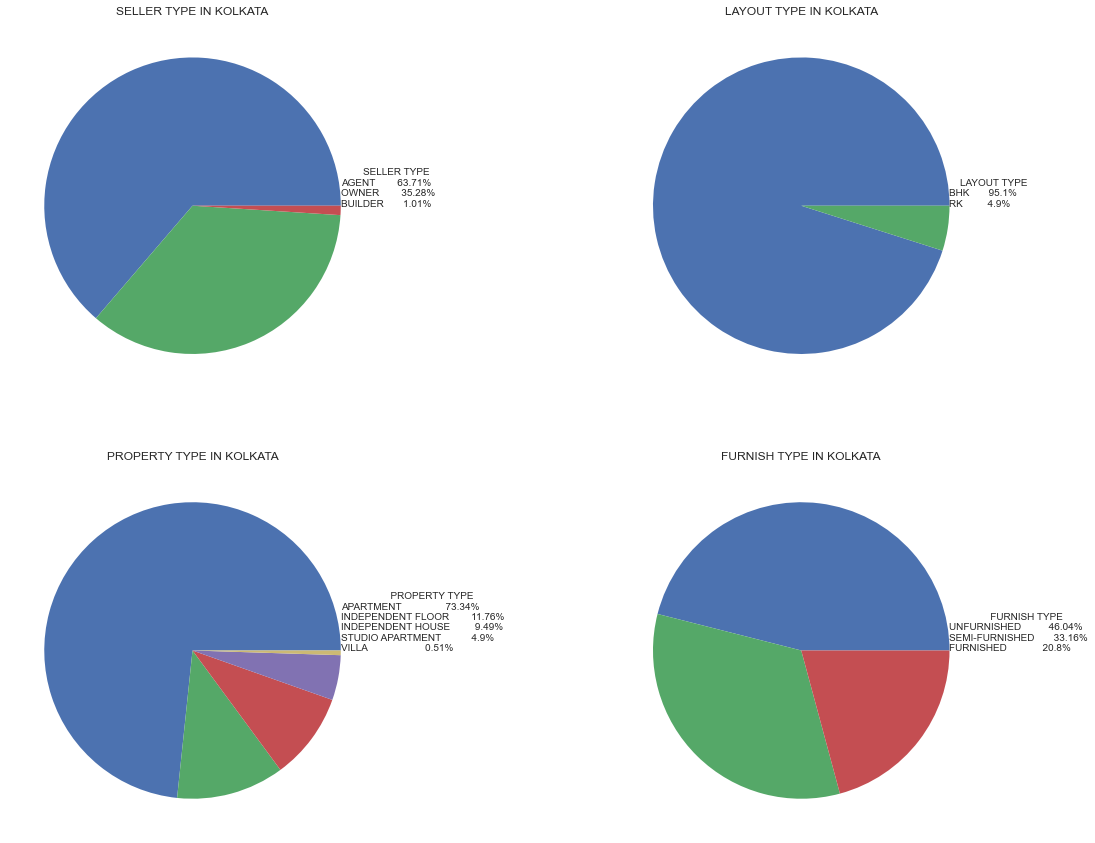

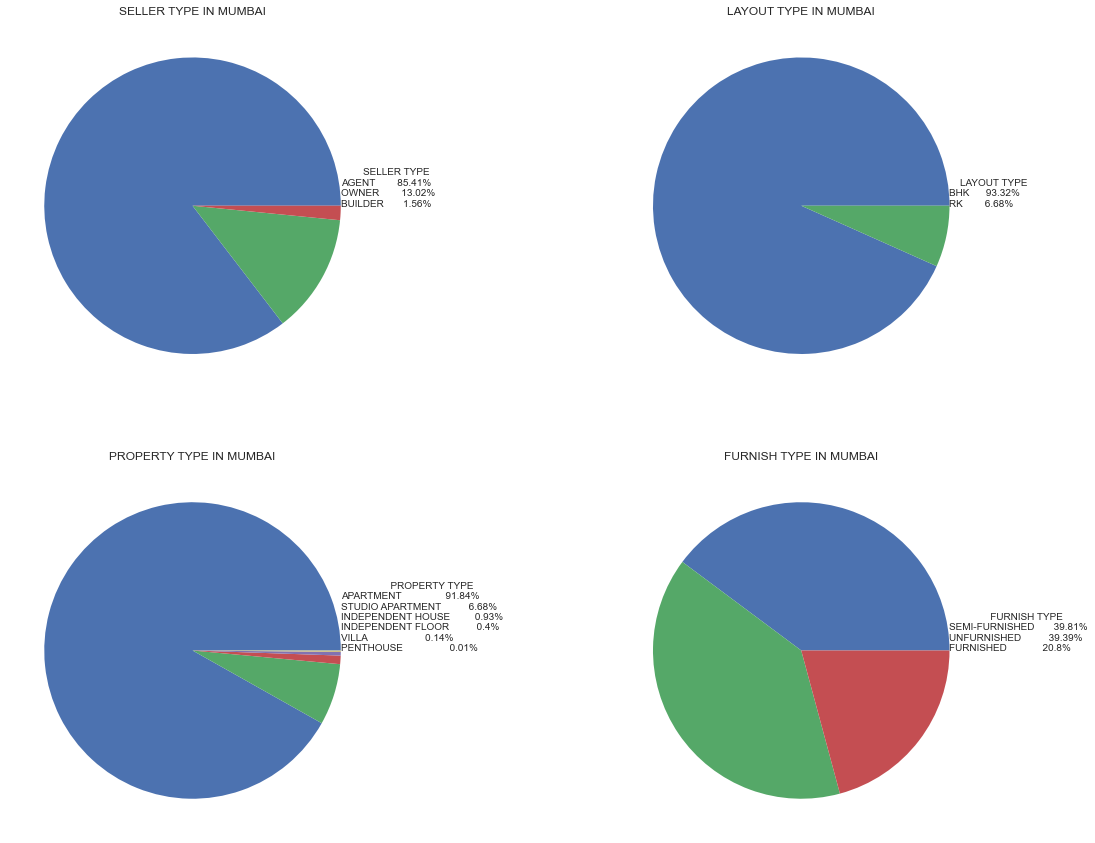

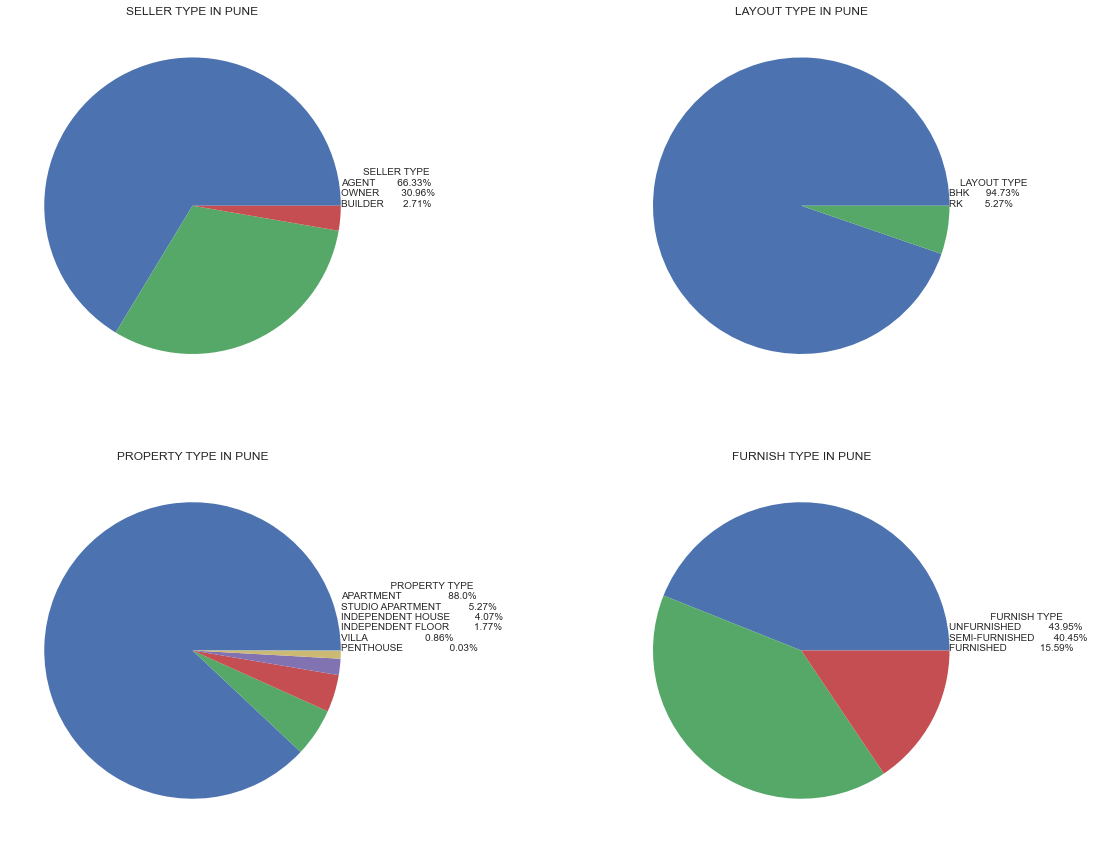

In [12]:
for city, df in df_dict.items():
    if not os.path.exists(os.path.join('outputs',city)): #check if the path exists 
        os.makedirs(os.path.join('outputs',city)) #if not, make the path 
    fig, ax = plt.subplots(figsize=PIE_FIGSIZE,nrows=PIE_NROWS, ncols=PIE_NCOLS) #create a fig with 2 rows and 2 cols 
    for i in range(PIE_NROWS): #loop through the rows 
        for j in range(PIE_NROWS): #loop through columns 
            vc_df = pd.DataFrame(df[pie_cols[i,j]].value_counts()) #create a value counts dataframe 
            vc_df[pie_cols[i,j]] = vc_df[pie_cols[i,j]].apply(lambda x: str(np.round((x/df.shape[0])*100,2)) + '%') 
            #convert the numbers to percentage 
            with open(os.path.join('outputs',city, f'{pie_cols[i,j]}.html'), 'w') as f: #open the output html file 
                f.write(vc_df.to_html()) #store the html output in that file (to be used in flask app)
            ax[i,j].pie(x=df[pie_cols[i,j]].value_counts()) #plot the pie chart 
            text = pd.DataFrame(df[pie_cols[i,j]].value_counts().apply(lambda x: f'{np.round((x/df.shape[0])*100,2)}%')) 
            # create the text to display on pie chart 
            text.index = text.index.str.upper() #convert text to upper case 
            text = text.to_string() #convert text to string 
            ax[i,j].text(1,0,text) #display text on pie chart
            ax[i,j].set_title(f'{pie_cols[i,j]} IN {city}') #set the title 
    if not os.path.exists(OTHER_PLOT_DESTINATION): #check if the path exists 
        os.makedirs(OTHER_PLOT_DESTINATION) #if not then create the path 
    plt.savefig(os.path.join(OTHER_PLOT_DESTINATION, f'{city}.png')) #save the figure 
    plt.show() #show the figure 

In [13]:
# create an array for analyzing numerical columns 
numerical_cols = np.array([
    ['PRICE','AREA'],
    ['BEDROOM','BATHROOM']
]).reshape(NUMERICAL_NROWS,NUMERICAL_NCOLS)

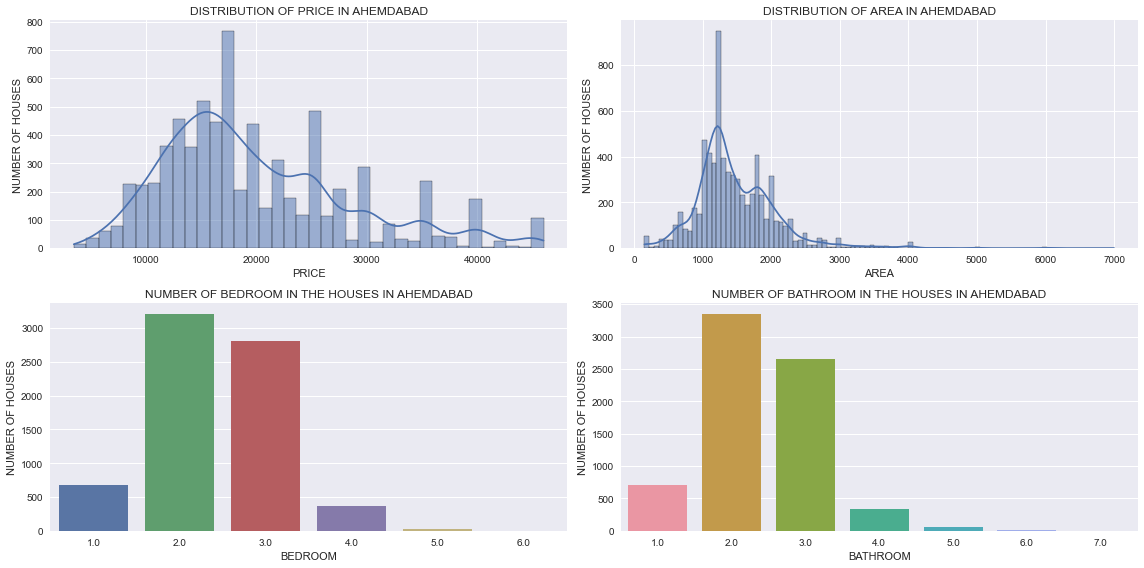

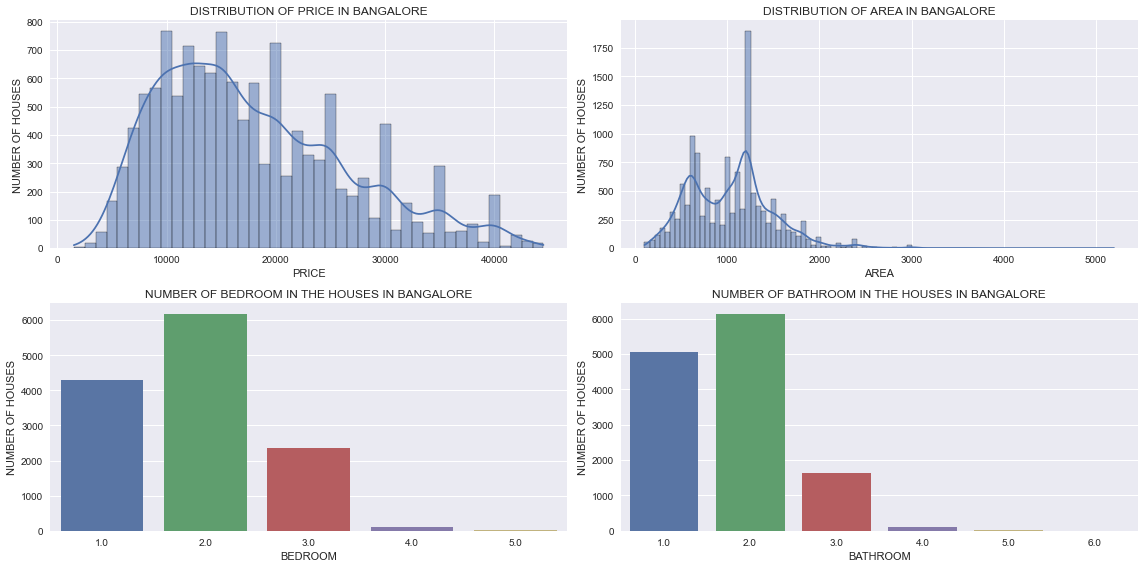

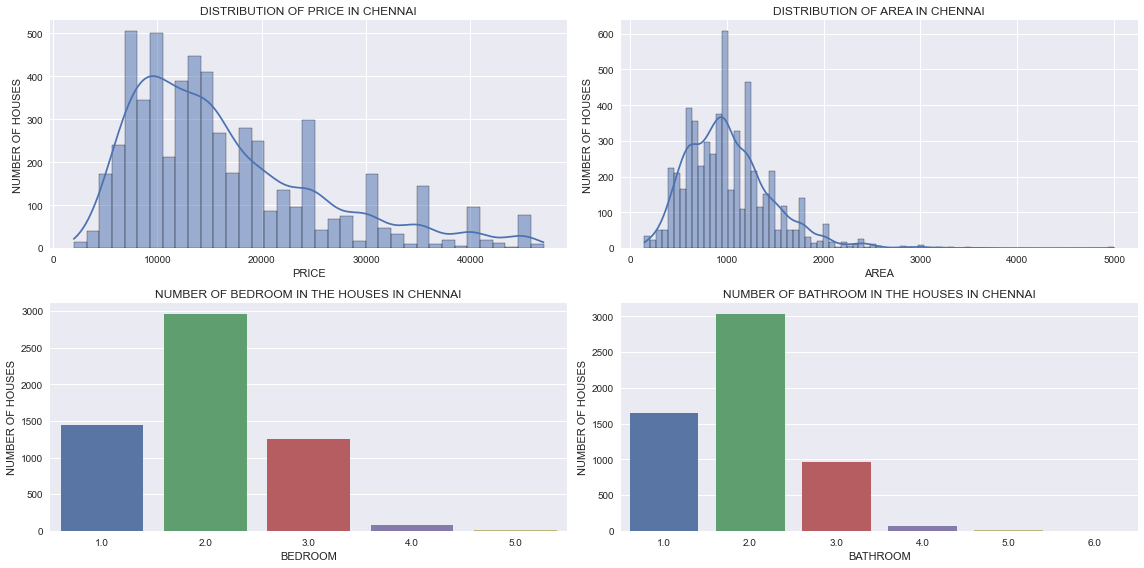

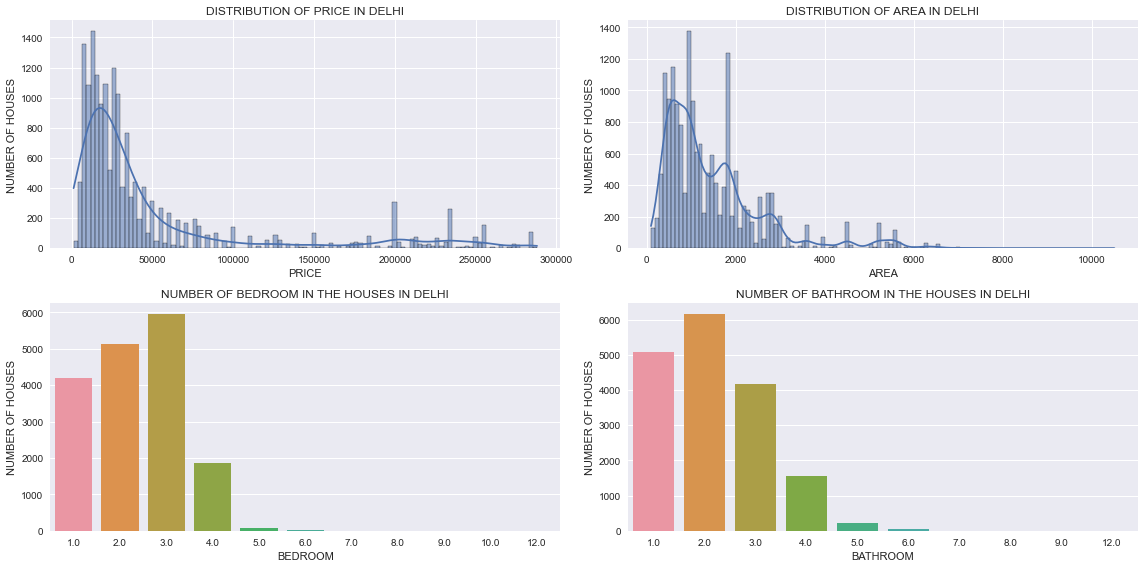

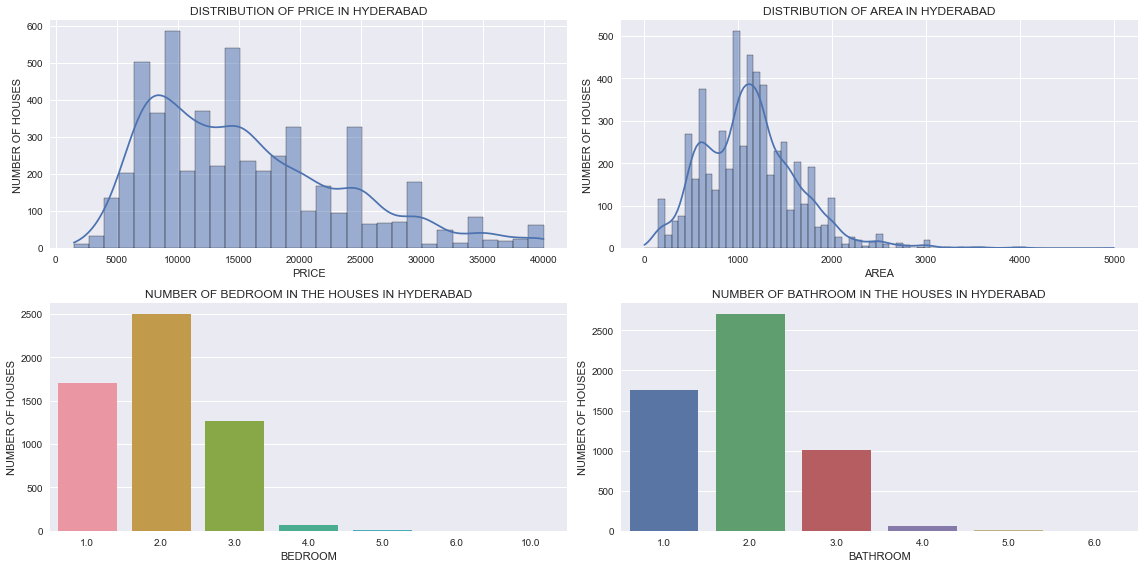

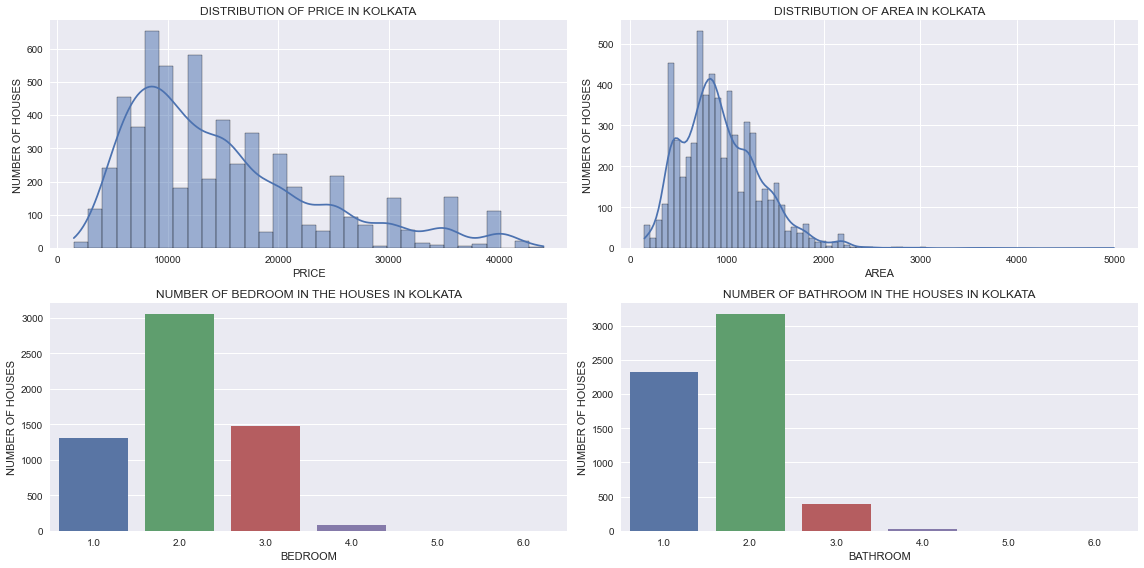

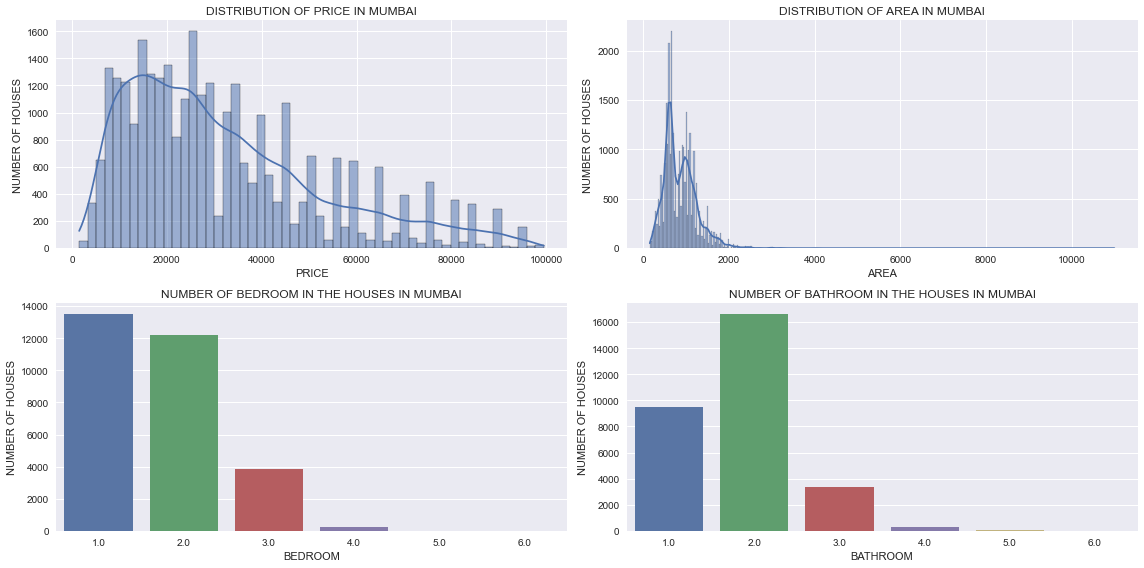

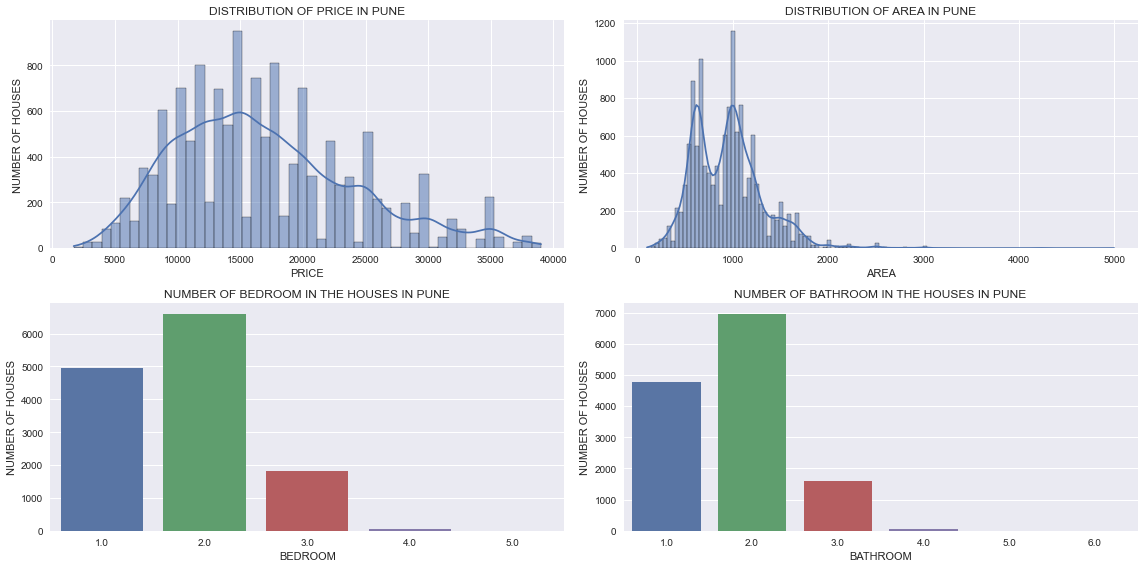

In [14]:
for city, df in df_dict.items():
    fig, ax = plt.subplots(figsize=MULTICOL_FIGSIZE,nrows=2,ncols=2) #create a matplotlib figure 
    for i in range(NUMERICAL_NROWS): #loop through the rows 
        for j in range(NUMERICAL_NCOLS): #loop through the columns 
            if i==0: # if it is the 1st row 
                sns.histplot(df[numerical_cols[i,j]],ax=ax[i,j],kde=True) #plot the distribution of column of ith row and jth column
                ax[i,j].set_title(f'DISTRIBUTION OF {numerical_cols[i,j]} IN {city}') # set the title 
                ax[i,j].set_xlabel(numerical_cols[i,j]) #set the xlabel 
                ax[i,j].set_ylabel('NUMBER OF HOUSES') #set the ylabel
            if i==1: #if it is the second row 
                sns.countplot(x=df[numerical_cols[i,j]],ax=ax[i,j]) #plot the countplot of column of ith row and jth column 
                ax[i,j].set_title(f'NUMBER OF {numerical_cols[i,j]} IN THE HOUSES IN {city}') #set the title 
                ax[i,j].set_xlabel(numerical_cols[i,j]) #set the xlabel
                ax[i,j].set_ylabel('NUMBER OF HOUSES') #set the ylabel
    plt.tight_layout() #apply tight layout to prevent overlap of columns  
    if not os.path.exists(NUMERICAL_PLOT_DESTINATION): #check if the path exists 
        os.makedirs(NUMERICAL_PLOT_DESTINATION) #if not then make the path 
    plt.savefig(os.path.join(NUMERICAL_PLOT_DESTINATION, f'{city}.png')) #save the figure at the path 
    plt.show() #show the figure 


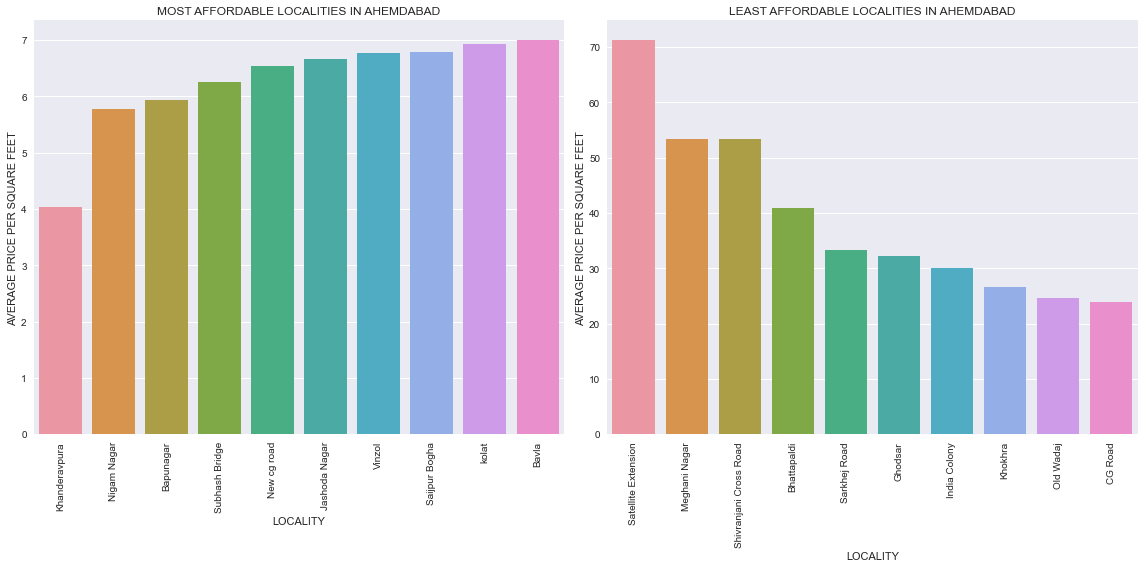

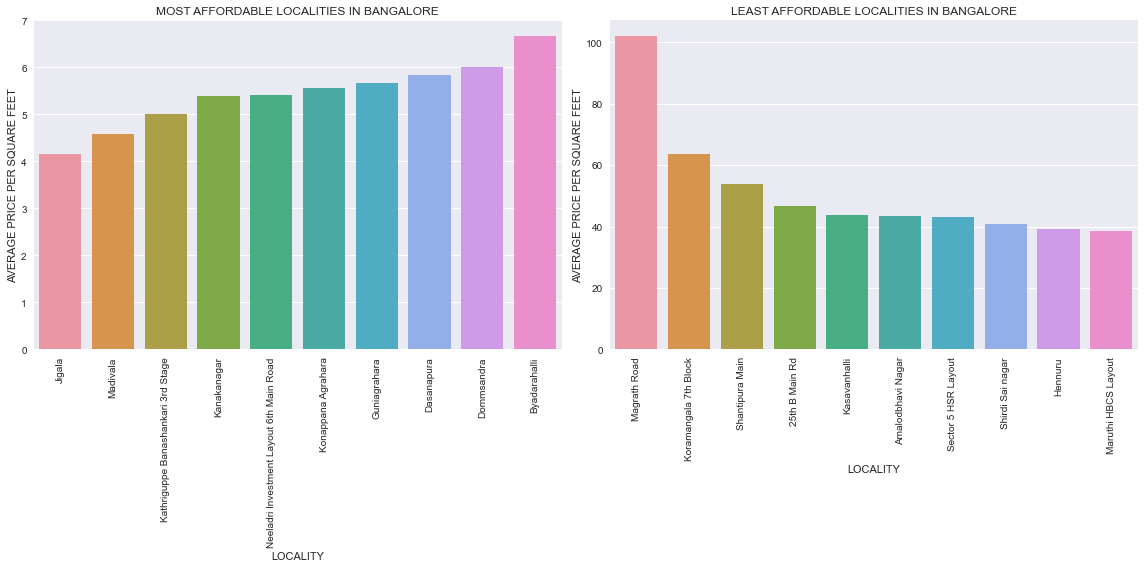

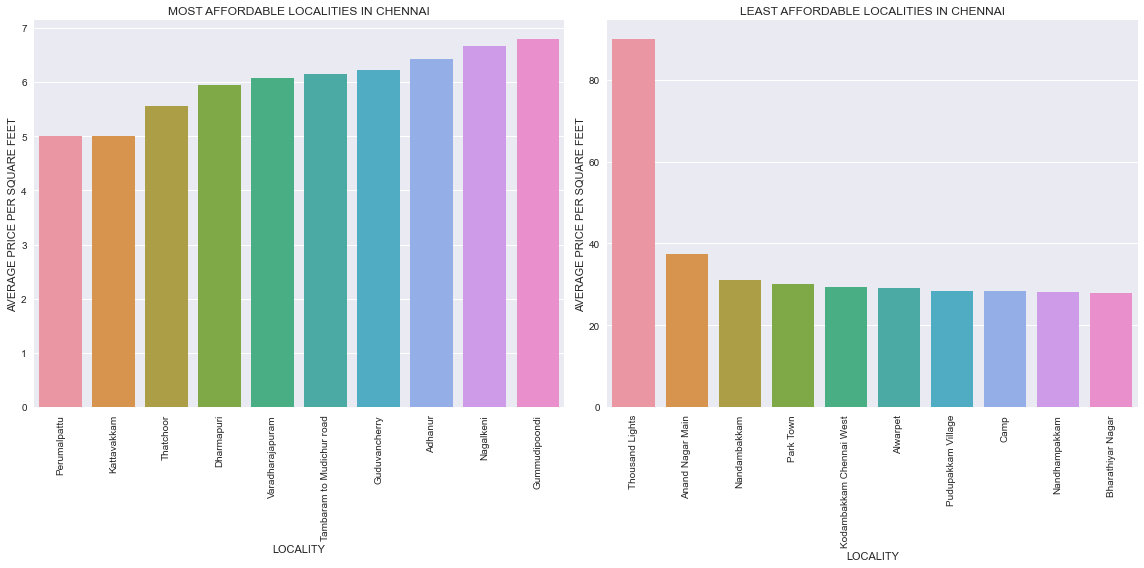

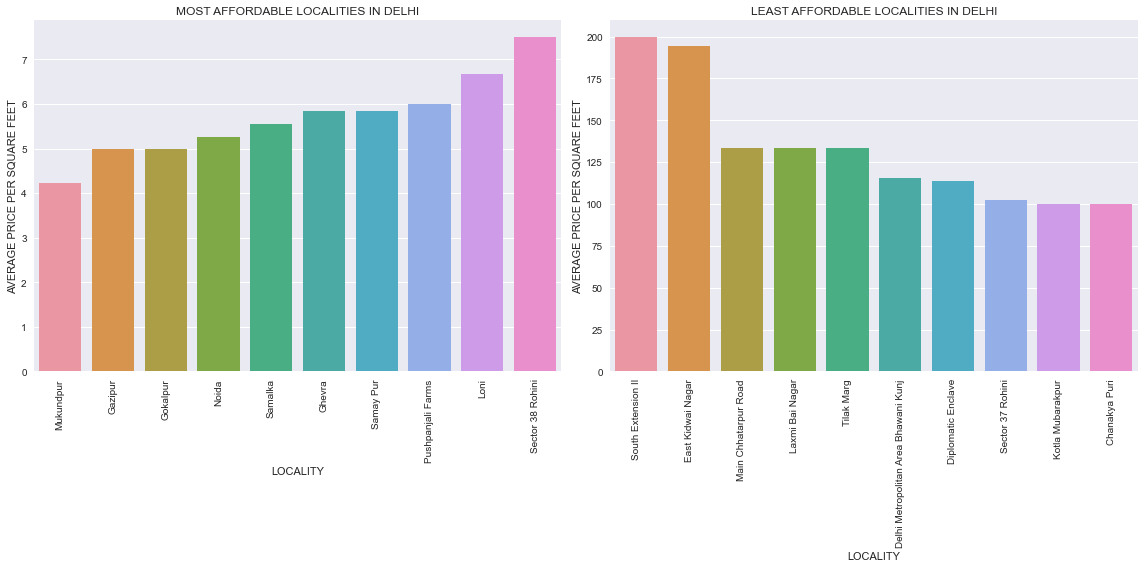

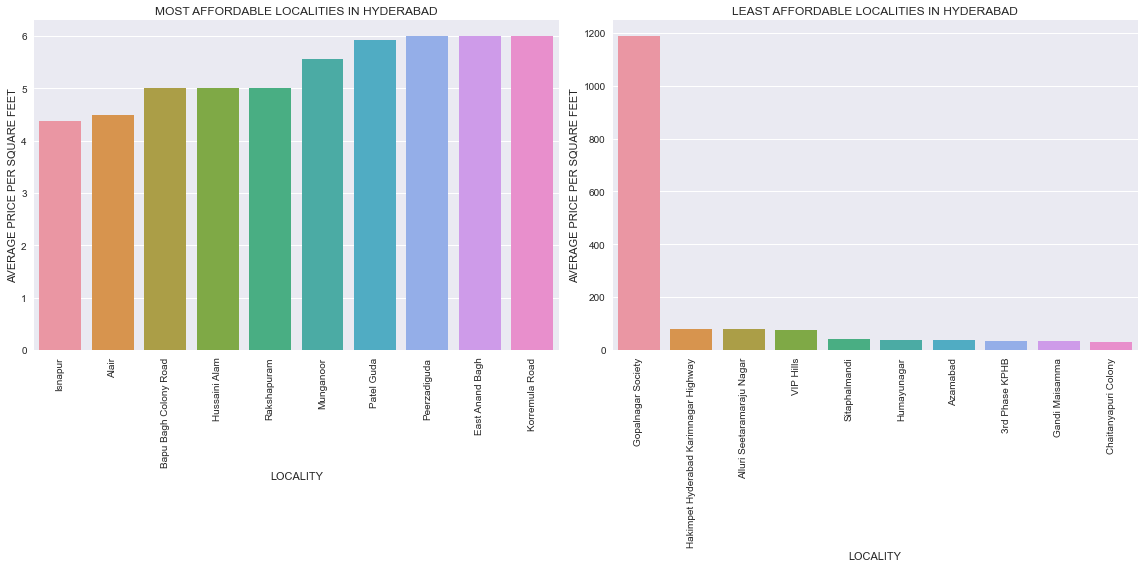

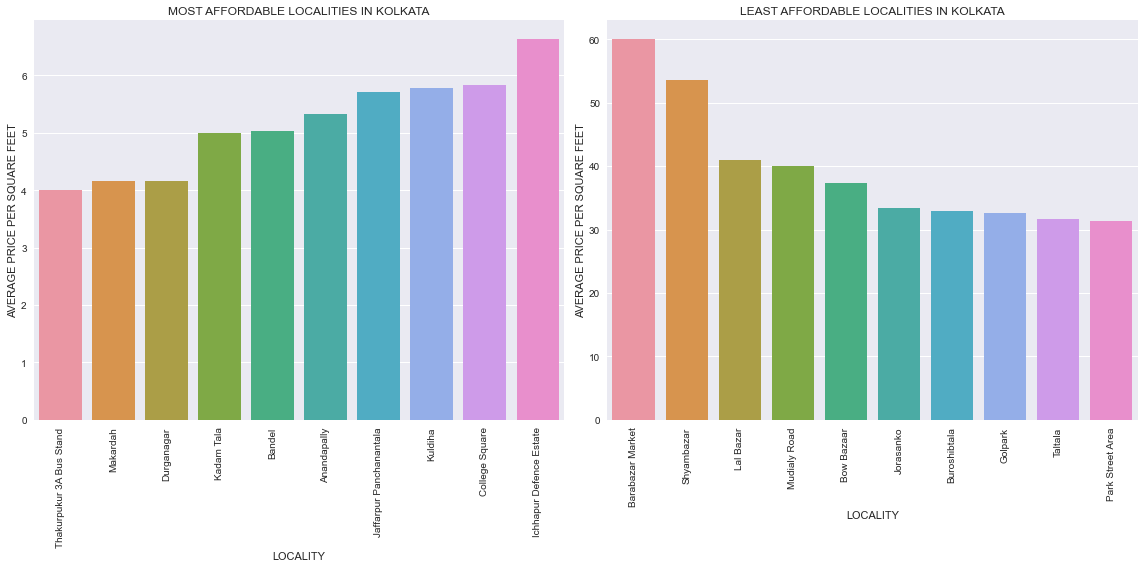

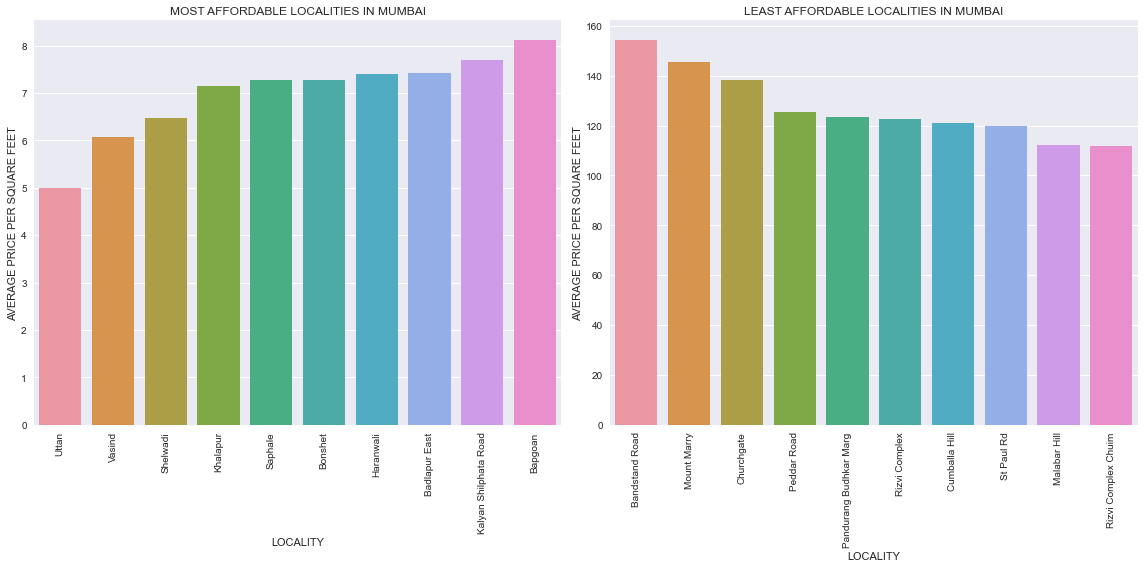

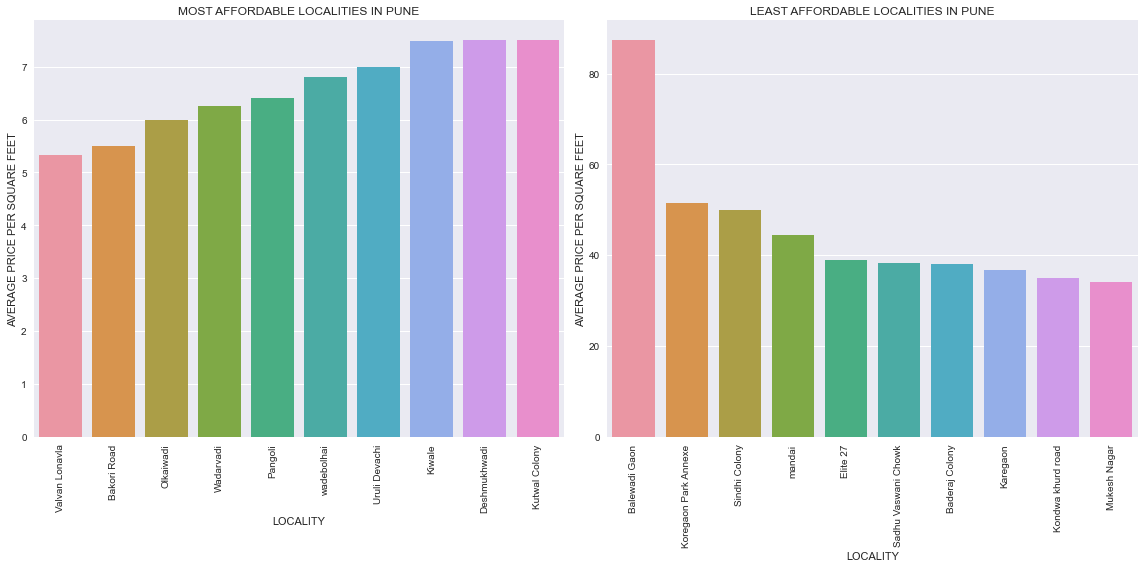

In [15]:
for city, df in df_dict.items():
    affordable = df.groupby(by=['LOCALITY'])['AFFORDABILITY'].mean() #calculate the mean price for each area
    most_affordable = affordable.sort_values(ascending=True)[:10] #sort them in ascending order for most affordable 
    least_affordable = affordable.sort_values(ascending=False)[:10] #sort them in descending order for least affordable
    fig, ax = plt.subplots(figsize=MULTICOL_FIGSIZE,nrows=1,ncols=2) #create a figure of 1 row and 2 cols 
    sns.barplot(x=most_affordable.index, y=most_affordable,ax=ax[0]) #plot the most affordable areas on 1st column 
    ax[0].set_title(f'MOST AFFORDABLE LOCALITIES IN {city}') #set the title 
    ax[0].set_xlabel('LOCALITY') #set the xlabel 
    ax[0].set_ylabel('AVERAGE PRICE PER SQUARE FEET') #set the ylabel 
    ax[0].tick_params(axis='x',labelrotation=90) #rotate the labels on x axis by 90 degrees for readibility
    sns.barplot(x=least_affordable.index, y=least_affordable, ax=ax[1]) #plot the least affordable areas on 2nd column 
    ax[1].set_title(f'LEAST AFFORDABLE LOCALITIES IN {city}') #set the title 
    ax[1].set_xlabel('LOCALITY') #set the xlabel 
    ax[1].set_ylabel('AVERAGE PRICE PER SQUARE FEET') #set the ylabel 
    ax[1].tick_params(axis='x',labelrotation=90) #rotate the labels on x axis by 90 degrees for readibility
    plt.tight_layout() #tight layout to prevent overlapping 
    if not os.path.exists(AFFORDABILITY_PLOT_DESTINATION): #check if the path exists
        os.makedirs(AFFORDABILITY_PLOT_DESTINATION) #if not, make the path 
    plt.savefig(os.path.join(AFFORDABILITY_PLOT_DESTINATION, f'{city}.png')) #save the figure 
    plt.show() #show the figure 

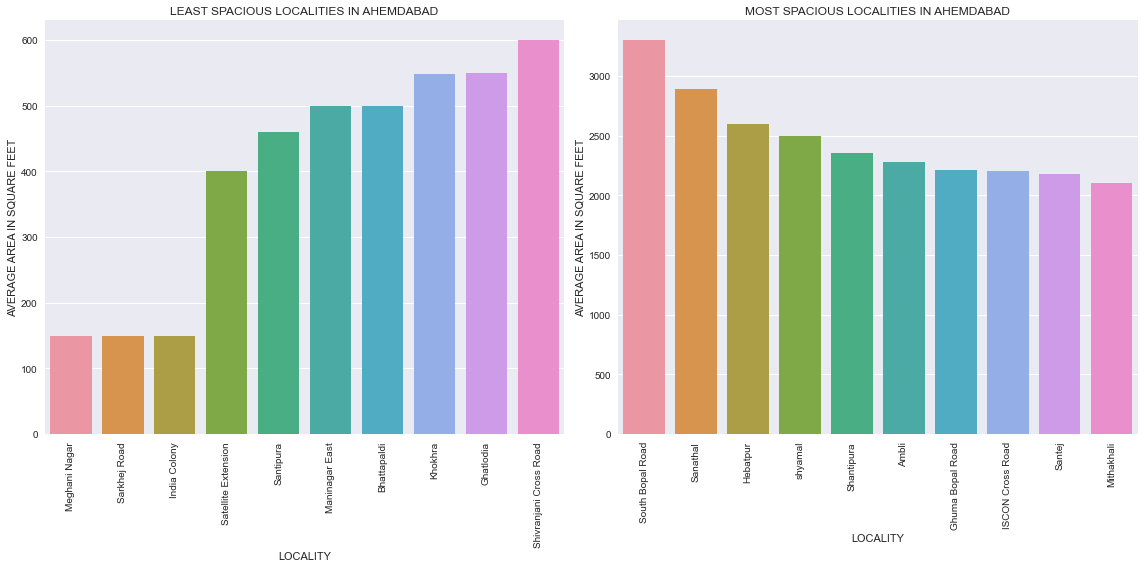

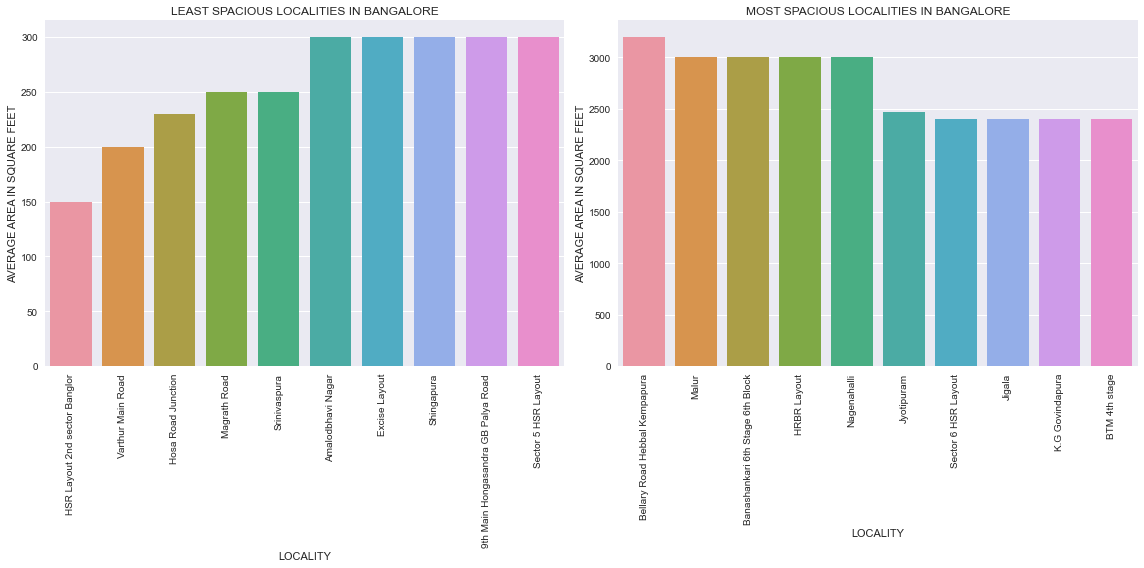

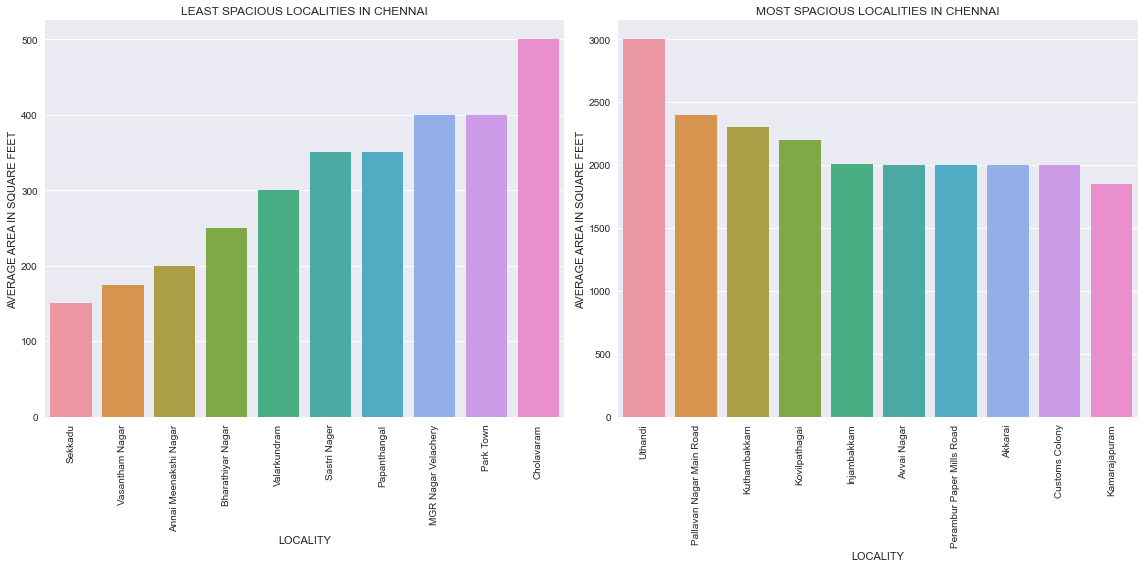

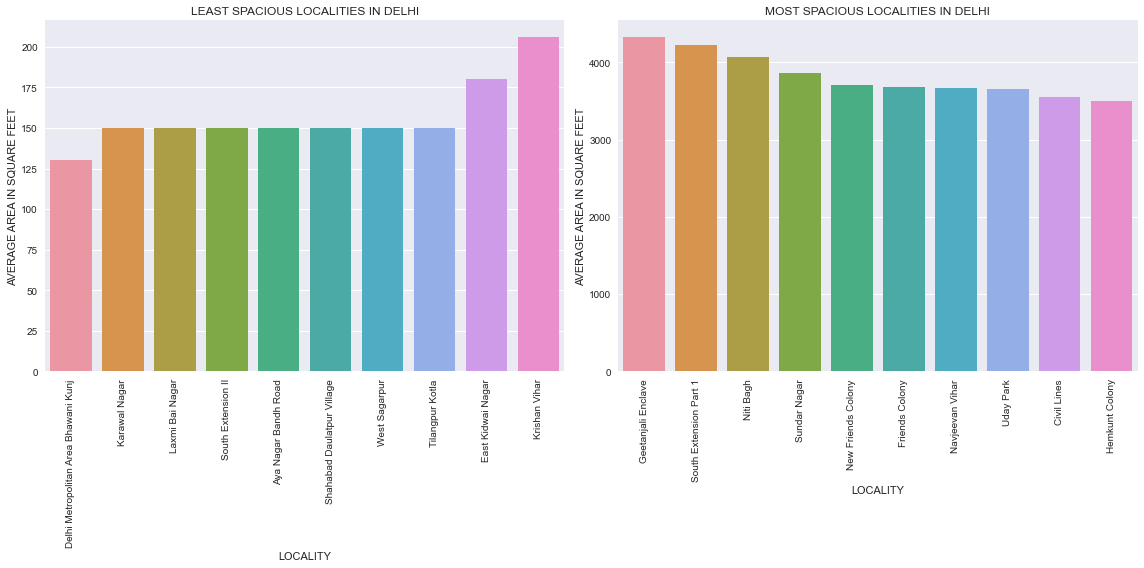

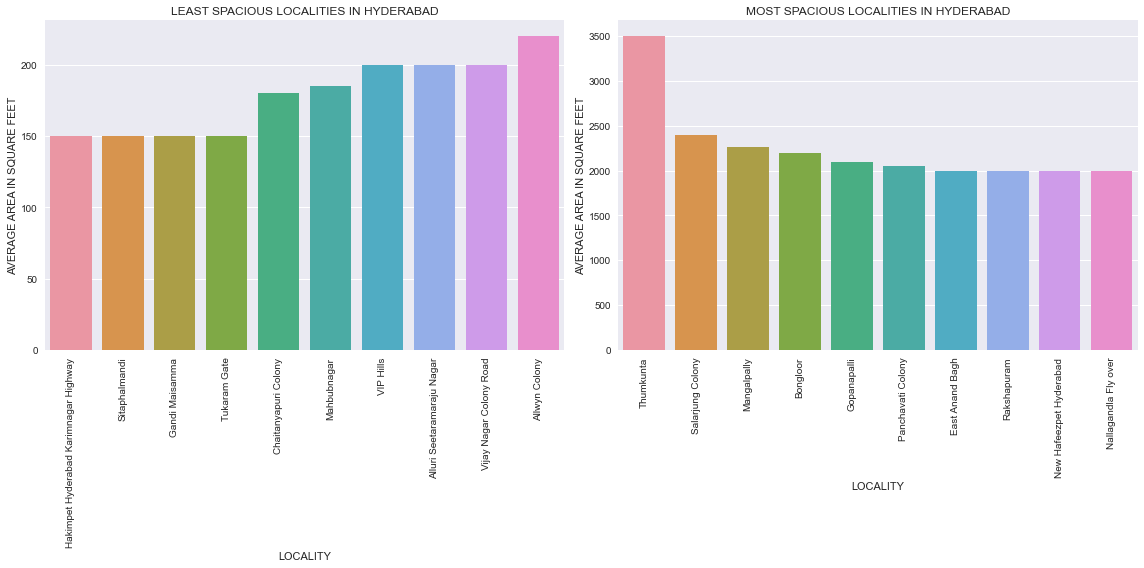

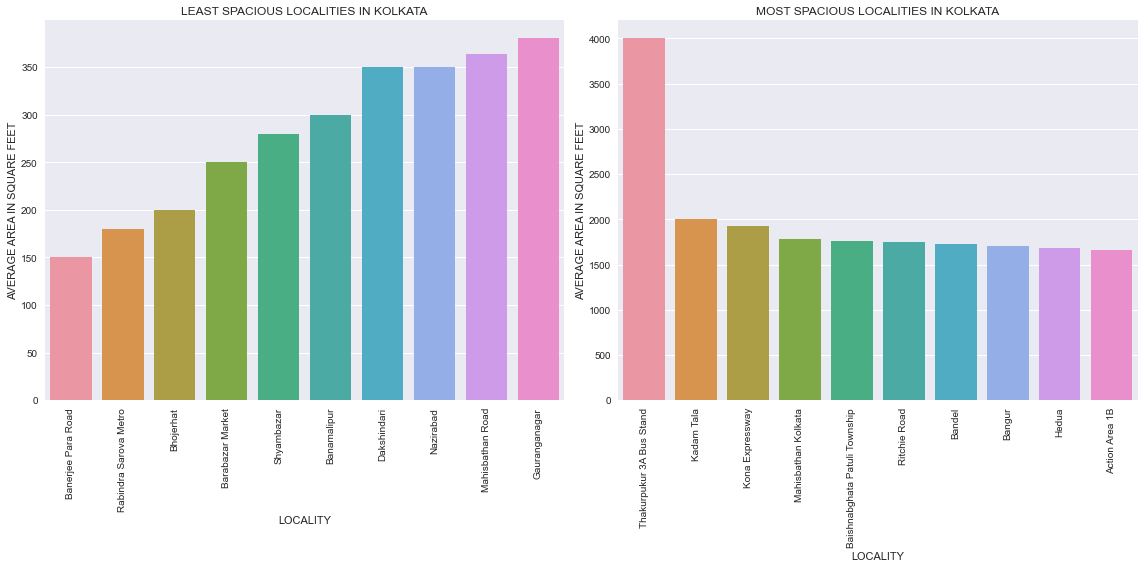

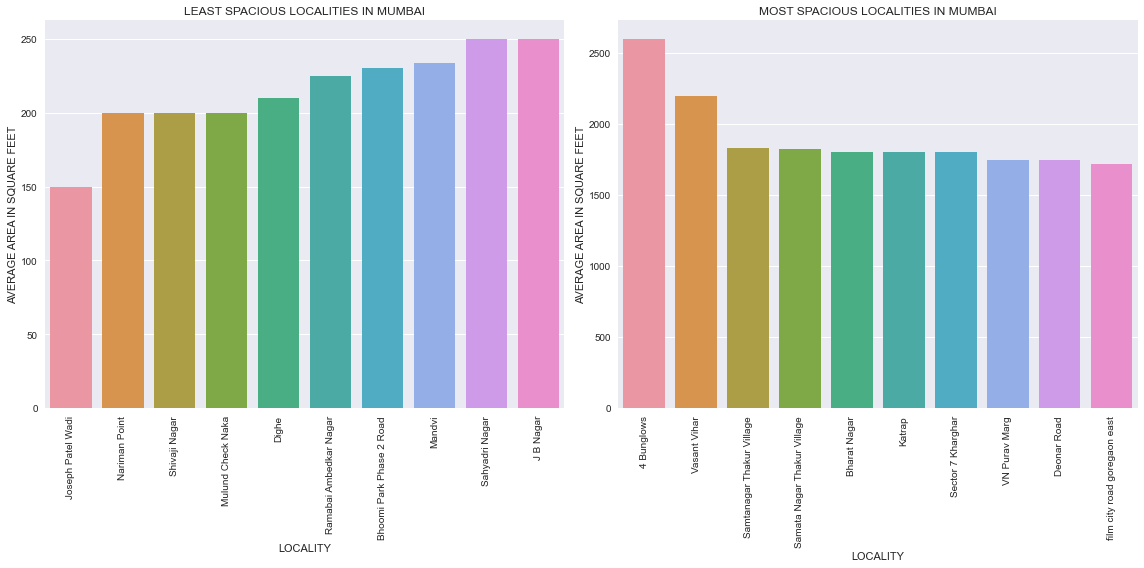

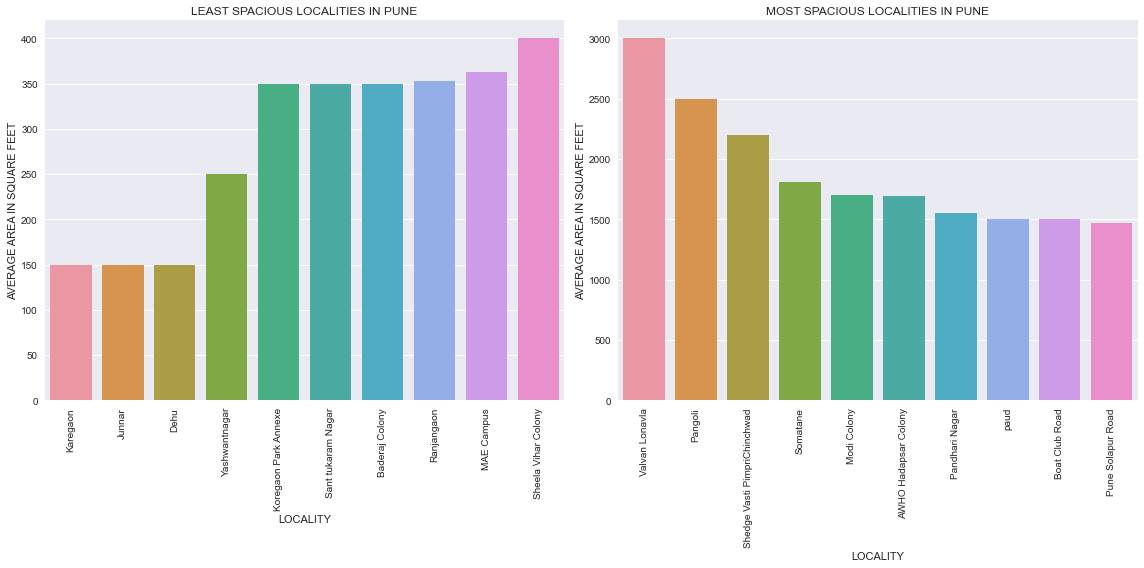

In [16]:
for city, df in df_dict.items():
    spacious = df.groupby(by=['LOCALITY'])['AREA'].mean() #calculate mean area for each locality 
    most_spacious = spacious.sort_values(ascending=False)[:10] #sort in ascending order for most spacious 
    least_spacious = spacious.sort_values(ascending=True)[:10] #sort in descending order for least spacious 
    fig, ax = plt.subplots(figsize=MULTICOL_FIGSIZE,nrows=1,ncols=2) #create figure with 1 row and 2 cols 
    sns.barplot(x=least_spacious.index, y=least_spacious, ax=ax[0]) #plot least spacious on 1st col 
    ax[0].set_title(f'LEAST SPACIOUS LOCALITIES IN {city}') #set title 
    ax[0].set_xlabel('LOCALITY') #set xlabel 
    ax[0].set_ylabel('AVERAGE AREA IN SQUARE FEET') #set ylabel
    ax[0].tick_params(axis='x',labelrotation=90) #rotate the labels on x axis by 90 degrees for readibility
    sns.barplot(x=most_spacious.index, y=most_spacious,ax=ax[1])#plot least affordable localities in 2nd column 
    ax[1].set_title(f'MOST SPACIOUS LOCALITIES IN {city}') 
    ax[1].set_xlabel('LOCALITY') #set xlabel 
    ax[1].set_ylabel('AVERAGE AREA IN SQUARE FEET') #set ylabel
    ax[1].tick_params(axis='x',labelrotation=90) #rotate the labels on x axis by 90 degrees for readibility
    plt.tight_layout() #apply tight layout for no overlap 
    if not os.path.exists(SPACIOUS_PLOT_DESTINATION): #check if path exists
        os.makedirs(SPACIOUS_PLOT_DESTINATION) #if not then create the path 
    plt.savefig(os.path.join(SPACIOUS_PLOT_DESTINATION, f'{city}.png')) #save the figure 
    plt.show() #show the plot 